# Estimates of root water uptake from soil moisture profile dynamics
Jupyter notebook supplement to the manuscript for publication in BG by Jackisch et al.

This study is part of the CAOS project (From catchments as organised systems to models based on functional units, Zehe et al. 2014, HESS).

(cc) c.jackisch@tu-braunschweig.de

In [1]:
#load required packages
%pylab inline
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as stats
import statsmodels.formula.api as smf 
import scipy.ndimage.filters as spf
import scipy as sp
import hydroeval as he

sns.set_style('whitegrid', {'grid.linestyle': u'--'})
matplotlib.rc('pdf', fonttype=42)

Populating the interactive namespace from numpy and matplotlib


In [2]:
#load/define used colour schemes

from palettable.tableau import Tableau_10
from palettable.tableau import Tableau_20
from palettable.cartocolors.qualitative import Bold_8
from palettable.colorbrewer.qualitative import Paired_12

#cm_t10 = plt.cm.get_cmap(Tableau_10.mpl_colormap)
cm_t10 = plt.cm.get_cmap(Bold_8.mpl_colormap)
cm_t20 = plt.cm.get_cmap(Tableau_20.mpl_colormap)

# These are the "Tableau 20" colors as RGB.  
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),  
         (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),  
         (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),  
         (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),  
         (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]  
# Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts.  
for i in range(len(tableau20)):  
    r, g, b = tableau20[i]  
    tableau20[i] = (r / 255., g / 255., b / 255.)  

tableau10=tableau20[0::2]


In [3]:
#load rootwater
import sys
sys.path.append('../rootwater') # Adds higher directory to python modules path.
import rootwater as rw
import sapflow as sf

In [84]:
#import importlib
#importlib.reload(sf)

<module 'sapflow' from '../rootwater/sapflow.py'>

## Load site data
The two sites are generally named Sand and Slate. They refer to the monitoring clusters SaD (Sand D) and SW (Slate W) of the CAOS project (From catchments as organised systems to models based on functional units, Zehe et al. 2014, HESS). 


The Meteorological reference data has been provided by the "Ministère de l'Agriculture, de la Viticulture et du Développement rural, Le Gouvernement du Grand-Duché de Luxembourg" through its web service https://www.agrimeteo.lu for the stations:

Roodt: https://www.am.rlp.de/Internet/AM/NotesLUAM.nsf/luxweb/348fc27901e88eb9c1257751003632b3

Useldange: https://www.am.rlp.de/Internet/AM/NotesLUAM.nsf/luxweb/64b5f9e78c267864c12577510032b918

We only use the pyranometer data from Useldange as reference.


Precipitation data has been provided by Malte Neuper (KIT) as corrected randar-derived canopy precipitation derrived from comined data of the DWD (Deutscher Wetterdienst, Germany), ASTA (Administration des Services techniques de l'agriculture, Luxembourg) and KNMI (Koninklijk Nederlands Meteorologisch Instituut, Netherlands).


The soil water retention data has been derrived from all 250 ml soil samples of the respective subbasin and depth layer (Jackisch et al. 2019, ESSD). 

In [18]:
#load site data of soil water content
SM = pd.read_csv('soilmoisture.csv',index_col=0)
SM.index = pd.to_datetime(SM.index)

#load sap velocity data
SV = pd.read_csv('sapvelocity.csv',index_col=0)
SV.index = pd.to_datetime(SV.index)

#load cluster precipitation and solar radiation data
prec_rad = pd.read_csv('precip_radiation.csv',index_col=0)
prec_rad.index = pd.to_datetime(prec_rad.index)

#load van Genuchten parameters
VGx = pd.read_csv('vG_RWU.csv',index_col=0).T

Load a van Genuchten pedo-transfer-model module and soil data.

Convert the recorded soil moisture data to matric potential by application of the retention function.

Text(0.5, 0, 'matric head pF (log10(hPa))')

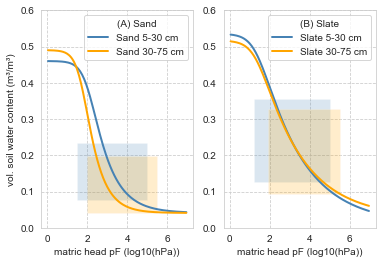

In [5]:
#show soils with given van Genuchten parameters
import vG_conv as vG

sup_dummy=np.arange(0.05,7.,0.05)
subplot(121)
lay=VGx.index[0]
thetad=vG.theta_psi((10**sup_dummy)/98.1,VGx.loc[lay,'ths'],VGx.loc[lay,'thr'],VGx.loc[lay,'alpha'],VGx.loc[lay,'n'],VGx.loc[lay,'m'])
plot(sup_dummy,0.01*thetad,'-',c='steelblue',lw=2,label=lay)
lay=VGx.index[1]
thetad=vG.theta_psi((10**sup_dummy)/98.1,VGx.loc[lay,'ths'],VGx.loc[lay,'thr'],VGx.loc[lay,'alpha'],VGx.loc[lay,'n'],VGx.loc[lay,'m'])
plot(sup_dummy,0.01*thetad,'-',c='orange',lw=2,label=lay)
fill_between([1.5,5],[0.0757, 0.0757],[0.2329,0.2329],facecolor='steelblue',alpha=0.2)
fill_between([2,5.5],[0.04175, 0.04175],[0.1982,0.1982],facecolor='orange',alpha=0.2)
ylim(0,0.6)
ylabel('vol. soil water content (m³/m³)')
xlabel('matric head pF (log10(hPa))')
legend(title='(A) Sand')

subplot(122)
lay=VGx.index[2]
thetad=vG.theta_psi((10**sup_dummy)/98.1,VGx.loc[lay,'ths'],VGx.loc[lay,'thr'],VGx.loc[lay,'alpha'],VGx.loc[lay,'n'],VGx.loc[lay,'m'])
plot(sup_dummy,0.01*thetad,'-',c='steelblue',lw=2,label=lay)
lay=VGx.index[3]
thetad=vG.theta_psi((10**sup_dummy)/98.1,VGx.loc[lay,'ths'],VGx.loc[lay,'thr'],VGx.loc[lay,'alpha'],VGx.loc[lay,'n'],VGx.loc[lay,'m'])
plot(sup_dummy,0.01*thetad,'-',c='orange',lw=2,label=lay)
fill_between([1.2,5],[0.12575,0.12575],[0.3556,0.3556],facecolor='steelblue',alpha=0.2)
fill_between([1.9,5.5],[0.0921,0.0921],[0.32767,0.32767],facecolor='orange',alpha=0.2)
ylim(0,0.6)
legend(title='(B) Slate')
xlabel('matric head pF (log10(hPa))')


In [6]:
#apply van Genuchten parameters to convert soil moisture to matric potential

MP = SM.copy()*np.nan
MP.columns = ['Sand_MP_10', 'Sand_MP_30', 'Sand_MP_50', 'Sand_MP_70', 'Sand_MP_90','Sand_MP_110', 'Sand_MP_130', 'Sand_MP_150', 'Sand_MP_170', 'Sand_MP_190', 'Sand_MP_210', 'Sand_MP_230', 
              'Slate_MP_10', 'Slate_MP_30', 'Slate_MP_50', 'Slate_MP_70', 'Slate_MP_90', 'Slate_MP_110', 'Slate_MP_130', 'Slate_MP_150', 'Slate_MP_170']

lay=VGx.index[0]
for j in ['10', '30']:
    MP['Sand_MP_'+j]= vG.psi_theta(SM['Sand_SM_'+j],VGx.loc[lay,'ths'],VGx.loc[lay,'thr'],VGx.loc[lay,'alpha'],VGx.loc[lay,'n'],VGx.loc[lay,'m'])

lay=VGx.index[1]
for j in ['50', '70', '90', '110', '130', '150', '170', '190', '210', '230']:
    MP['Sand_MP_'+j]= vG.psi_theta(SM['Sand_SM_'+j],VGx.loc[lay,'ths'],VGx.loc[lay,'thr'],VGx.loc[lay,'alpha'],VGx.loc[lay,'n'],VGx.loc[lay,'m'])

lay=VGx.index[2]
for j in ['10', '30']:
    MP['Slate_MP_'+j]= vG.psi_theta(SM['Slate_SM_'+j],VGx.loc[lay,'ths'],VGx.loc[lay,'thr'],VGx.loc[lay,'alpha'],VGx.loc[lay,'n'],VGx.loc[lay,'m'])

lay=VGx.index[3]
for j in ['50', '70', '90', '110', '130', '150', '170']:
    MP['Slate_MP_'+j]= vG.psi_theta(SM['Slate_SM_'+j],VGx.loc[lay,'ths'],VGx.loc[lay,'thr'],VGx.loc[lay,'alpha'],VGx.loc[lay,'n'],VGx.loc[lay,'m'])


## Root water uptake calculation

The actual algorithm is given in an external file als python function. Here some examples are given.

In [19]:
# example time series in slate site:
start=pd.to_datetime('2017-06-12 04:00:00')
stop=pd.to_datetime('2017-06-14 04:00:00')

ts = SM.loc[start:stop,'Slate_SM_70']
ts = ts.tz_localize('Etc/GMT-1')
dif_ts = pd.Series(spf.gaussian_filter1d(ts.diff(3),1))
dif_ts.index = ts.index

In [20]:
#call RWU calculation function fRWU
rwux = rw.fRWU(ts)
dif_ts = pd.Series(spf.gaussian_filter1d(ts.diff(3),1))
dif_ts.index = ts.index
dd=rwux.index[1]

In [21]:
rwux

,rwu,rwu_nonight,lm_night,lm_day,step_control,evalx,eval_nse,tin,tout,tix
2017-06-12,NaN,NaN,NaN,NaN,2.0,0.0,0.984979,2017-06-12 04:00:00+01:00,2017-06-12 05:30:00+01:00,2017-06-12 21:30:00+01:00
2017-06-13,0.403992,0.355,0.00081,-0.01667,1111.0,1.0,0.949938,2017-06-12 20:00:00+01:00,2017-06-13 08:00:00+01:00,2017-06-13 21:00:00+01:00
2017-06-14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Example of observed solar radiation, sap velocity and soil moisture during three days of the vegetation period. The example is from the sandy site dataset, soil moisture values are in 0.7 m depth.

In [22]:
#get sunrise/sunset from astral (included in rwu function)
from astral import Location

l = Location()
l.latitude = 49.70764
l.longitude = 5.897638
l.timezone = 'Etc/GMT-1'
l.elevation = 200

#sunrise sunset
def sunr(dd):
    # give date and return time of sunrise
    sunrise = pd.to_datetime(l.sun(date=dd)['sunrise'])
    return sunrise
    
def suns(dd):
    # give date and return time of sunset
    sunset = pd.to_datetime(l.sun(date=dd)['sunset'])
    return sunset

([<matplotlib.axis.XTick at 0x1a26f8d358>,
 <a list of 7 Text xticklabel objects>)

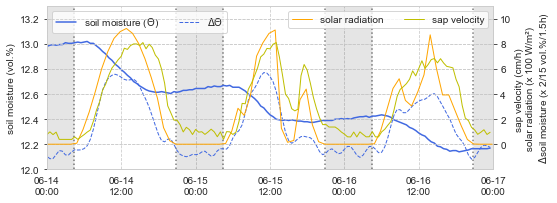

In [25]:

figsize(8,3)

soil=SM.loc['2017-06-12':'2017-06-16','Sand_SM_70']
ray=prec_rad.loc['2017-06-12':'2017-06-16','Rad']/100
saps=SV.loc['2017-06-12':'2017-06-16','Sand_SV_inner']

dif_ts = pd.Series(spf.gaussian_filter1d(soil.diff(3),1))
dif_ts.index = soil.index

fig, ax1 = plt.subplots()
ax1.plot(soil.index,soil,c='royalblue',linestyle='-',label='soil moisture ($\Theta$)')
ax1.plot(dif_ts.index,-7.5*(dif_ts)+12.2,c='royalblue',linestyle='--',lw=1,label='$\Delta \Theta$')
ax1.set_ylabel('soil moisture (vol.%)')
ax1.set_ylim([12.,13.3])
ax1.set_xlim(['2017-06-14','2017-06-17 00:00:00'])

#dates to consider:
ddx = soil.resample('1d').mean().index.date

for i in np.arange(len(ddx)):
    sus = pd.to_datetime(l.sun(date=ddx[i])['sunset'])+datetime.timedelta(hours=1)
    sur = pd.to_datetime(l.sun(date=ddx[i]+datetime.timedelta(hours=24))['sunrise'])+datetime.timedelta(hours=1)
    ax1.vlines(sus,12.,13.3,'k',':',alpha=0.5)
    ax1.vlines(sur,12.,13.3,'k',':',alpha=0.5)
    if i == len(ddx)-1:
        ax1.fill_betweenx([12.,13.3],[sus,sus],[sur,sur],facecolor='k',alpha=0.1)#,label='astron. night')
    else:
        ax1.fill_betweenx([12.,13.3],[sus,sus],[sur,sur],facecolor='k',alpha=0.1)
        
ax1.legend(loc=2,ncol=2)
ax2 = ax1.twinx()
yticks(np.arange(0,17,2),np.arange(0,17,2))
leg2,=ax2.plot(ray.index,ray,c='orange',linestyle='-',lw=1,label='solar radiation')
leg3,=ax2.plot(saps.index,saps,c='y',linestyle='-',lw=1,label='sap velocity')
ax2.set_ylabel('sap velocity (cm/h) \n solar radiation (x 100 W/m²) \n $\Delta$soil moisture (x 2/15 vol.%/1.5h)')

ax2.set_ylim([-2,11])
ax2.legend([leg2,leg3,],['solar radiation','sap velocity'],loc=1,ncol=2)
ax2.set_xlim(['2017-06-14','2017-06-17 00:00:00'])

xticks(SM.loc['2017-06-14':'2017-06-17 00:00:00'].resample('12h').mean().index,['06-14\n00:00','06-14\n12:00','06-15\n00:00','06-15\n12:00','06-16\n00:00','06-16\n12:00','06-17\n00:00'])
#


Visualisation of calculation of root water uptake from soil moisture change of one day in one soil layer.

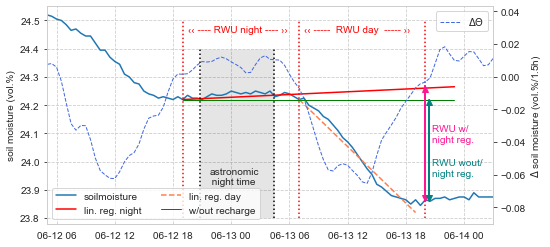

In [26]:
figsize(8,4)

plot(ts,label='soilmoisture') 
n=int(np.round(len(ts)/1.7))

plot(pd.date_range(rwux.loc[dd,'tin'], periods=n, freq='30min'),ts.loc[rwux.loc[dd,'tin']]+rwux.loc[dd,'lm_night']*np.arange(n),'r-',label='lin. reg. night')
plot(pd.date_range(rwux.loc[dd,'tout'], periods=25, freq='30min'),ts.loc[rwux.loc[dd,'tout']]+rwux.loc[dd,'lm_day']*np.arange(25),'--',c='coral',label='lin. reg. day')
plot(pd.date_range(rwux.loc[dd,'tin'], periods=n, freq='30min'),ts.loc[rwux.loc[dd,'tin']]*np.ones(n),'g-',label='w/out recharge',lw=1)

#identified times
plot([rwux.loc[dd,'tin'],rwux.loc[dd,'tin']],[23.8,24.5],'r:')
text(rwux.loc[dd,'tin']+datetime.timedelta(hours=0.5),24.46,'‹‹ ---- RWU night ---- ››',color='red')
text(rwux.loc[dd,'tout']+datetime.timedelta(hours=0.5),24.46,'‹‹ -----  RWU day  ----- ››',color='red')

plot([rwux.loc[dd,'tout'],rwux.loc[dd,'tout']],[23.8,24.5],'r:')
plot([rwux.loc[dd,'tix'],rwux.loc[dd,'tix']],[23.8,24.5],'r:')

#night
sus = pd.to_datetime(l.sun(date=rwux.index[0])['sunset'])+datetime.timedelta(hours=1)
sur = pd.to_datetime(l.sun(date=dd)['sunrise'])+datetime.timedelta(hours=1)
plot([sus,sus],[23.8,24.4],'k:')
plot([sur,sur],[23.8,24.4],'k:')
fill_betweenx([23.8,24.4],[sus,sus],[sur,sur],facecolor='k',alpha=0.1)
text(sus+datetime.timedelta(hours=1),23.92,'astronomic\n night time')

plot([rwux.loc[dd,'tix'],rwux.loc[dd,'tix']],[ts.loc[rwux.loc[dd,'tix']],ts.loc[rwux.loc[dd,'tix']]+rwux.loc[dd,'rwu']],'-',lw=2,c='deeppink')#,label='RWU w/ night reg.')
plot(rwux.loc[dd,'tix'],ts.loc[rwux.loc[dd,'tix']]+0.007,"v",c='deeppink')
plot(rwux.loc[dd,'tix'],ts.loc[rwux.loc[dd,'tix']]+rwux.loc[dd,'rwu']-0.01,"^",c='deeppink')
plot([rwux.loc[dd,'tix']+datetime.timedelta(hours=0.4),rwux.loc[dd,'tix']+datetime.timedelta(hours=0.4)],[ts.loc[rwux.loc[dd,'tix']],ts.loc[rwux.loc[dd,'tix']]+rwux.loc[dd,'rwu_nonight']],'-',lw=2,c='teal')#,label='RWU wout/ night reg.')
plot(rwux.loc[dd,'tix']+datetime.timedelta(hours=0.4),ts.loc[rwux.loc[dd,'tix']]+0.007,"v",c='teal')
plot(rwux.loc[dd,'tix']+datetime.timedelta(hours=0.4),ts.loc[rwux.loc[dd,'tix']]+rwux.loc[dd,'rwu_nonight']-0.01,"^",c='teal')

text(rwux.loc[dd,'tix']+datetime.timedelta(hours=0.7),24.07,'RWU w/\nnight reg.',color='deeppink')
text(rwux.loc[dd,'tix']+datetime.timedelta(hours=0.7),23.95,'RWU wout/\nnight reg.',color='teal')

xlim(pd.to_datetime('2017-06-12 05:00:00'),pd.to_datetime('2017-06-14 03:00:00'))
ylabel('soil moisture (vol.%)')
ylim(23.78,24.55)
legend(ncol=2,loc=3)

twinx()
plot(dif_ts,c='royalblue',linestyle='--',lw=1,label='$\Delta \Theta$')
ylim(-0.09,0.043)
ylabel('$\Delta$ soil moisture (vol.%/1.5h)')
grid(False)
legend(loc=1)



## Sap velocity to sap flow conversion

In [27]:
# plot function for stacked time series
def stackplot(A):
    fill_between(A.index,A.iloc[:,2],facecolor=tableau10[0],alpha=0.7,color='b',lw=0,label=A.columns[2])
    fill_between(A.index,A.iloc[:,[1,2]].sum(axis=1),A.iloc[:,2],facecolor=tableau10[2],alpha=0.7,color='g',lw=0,label=A.columns[1])
    fill_between(A.index,A.iloc[:,:3].sum(axis=1),A.iloc[:,[1,2]].sum(axis=1),facecolor=tableau10[3],alpha=0.7,color='y',lw=0,label=A.columns[0])

The measured sap velocity requires conversion into a flux through the rotation-symmetrical sap-wood. We use an approach considering sap-wood thickness, bark thickness and an exponential sap velocity distribution. The following functions are defined:

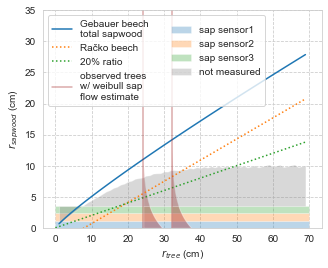

In [28]:
# different estimates about sapwood area based on DBH-radius

figsize(5,4)
r= np.arange(70)
perc = 0.95

#East30 thermocouplers location at needles 5, 18 and 30 mm
fill_between([0,70],[0,0],[1.1,1.1],alpha=0.3,label='sap sensor1')
fill_between([0,70],[1.1,1.1],[2.4,2.4],alpha=0.3,label='sap sensor2')
fill_between([0,70],[2.4,2.4],[3.5,3.5],alpha=0.3,label='sap sensor3')

#gebauer
plot(r,sf.gebauer(r),label='Gebauer beech \ntotal sapwood')

#other
plot(r,sf.recko(r,True),':',label='Račko beech')
plot(r,0.2*r,':',label='20% ratio')
#plot(r,galvac(r),':',label='Galvac')

plot([32.1,32.1],[0,70],c='brown',alpha=0.4)
fill_between(32.+sf.gebauer_rel(32.),np.arange(50)/50.*sf.gebauer(32.),facecolor='brown',alpha=0.4)
plot([24.2,24.2],[0,70],c='brown',alpha=0.4,label='observed trees\nw/ weibull sap \nflow estimate')
fill_between(24.+sf.gebauer_rel(24.),np.arange(50)/50.*sf.gebauer(24.),facecolor='brown',alpha=0.4)

fill_between(r,np.ones(70)*3.5,sf.gebauer_act(r,perc),alpha=0.3,facecolor='grey',label='not measured')

xlabel('$r_{tree}$ (cm)')
ylabel('$r_{sapwood}$ (cm)')#'/ $r_{tree}$')
ylim(0.,35)

legend(loc=2,ncol=2)




In [29]:
tst = pd.to_datetime('2017-06-14')
tnd = pd.to_datetime('2017-06-15')

Text(0.5, 0, 'distance into tree (cm)')

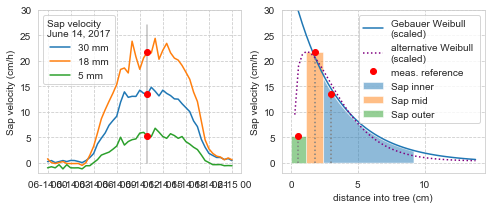

In [30]:
figsize(8,3)
ti = 13.
subplot(121)
plot(SV.loc[tst:tnd,['Slate_SV_inner']],label='30 mm')
plot(SV.loc[tst:tnd,['Slate_SV_mid']],label='18 mm')
plot(SV.loc[tst:tnd,['Slate_SV_outer']],label='5 mm')
plot([tst+pd.to_timedelta(ti, unit='h'),tst+pd.to_timedelta(ti, unit='h')],[0,27],'-',c='grey',alpha=0.5)
plot([tst+pd.to_timedelta(ti, unit='h'),tst+pd.to_timedelta(ti, unit='h'),tst+pd.to_timedelta(ti, unit='h')],SV.loc[tst+pd.to_timedelta(ti, unit='h'),['Slate_SV_outer','Slate_SV_mid','Slate_SV_inner']],'ro')
ylim(-2,30)
ylabel('Sap velocity (cm/h)')
legend(title='Sap velocity\nJune 14, 2017')

subplot(122)
r1=32.
[s2,s1,s0] = SV.loc[tst+pd.to_timedelta(ti, unit='h'),['Slate_SV_inner','Slate_SV_mid','Slate_SV_outer']].values
dummyx=np.arange(50)/50.*sf.gebauer(r1)
plot(dummyx,sf.sap_volume(r1,s1,s2,True),label='Gebauer Weibull \n(scaled)')
plot(dummyx,(sf.gebauer_weibull(dummyx,a=2.14,b=3.08,c=1.27,d=2.)-0.2)*(24.),':',c='purple',label='alternative Weibull \n(scaled)')
fill_between(np.arange(2.4,sf.gebauer_act(r1),sf.gebauer(r1)/50.),sf.sap_volume(r1,s1,s2,True)[(np.arange(50)/50.*sf.gebauer(r1) > 2.4) & (np.arange(50)/50.*sf.gebauer(r1) <= sf.gebauer_act(r1))],label='Sap inner',alpha=0.5)
fill_between([1.1,2.4],[s1,s1],label='Sap mid',alpha=0.5)
fill_between([0.,1.1],[s0,s0],label='Sap outer',alpha=0.5)
plot([3.,3.],[0.,s2],':',c='grey')
plot(3.,s2,'ro',label='meas. reference')
plot([1.8,1.8],[0.,s1],':',c='grey')
plot(1.8,s1,'ro')
plot([0.5,0.5],[0.,s0],':',c='grey')
plot(0.5,s0,'ro')
ylim(-2,30)
legend()
ylabel('Sap velocity (cm/h)')
xlabel('distance into tree (cm)')



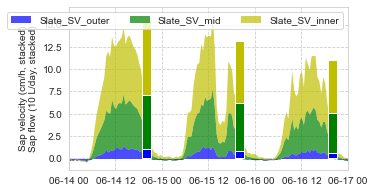

In [33]:

dummydate = pd.date_range('2017-06-14',periods=5)
tst = pd.to_datetime('2017-06-14')
tnd = pd.to_datetime('2017-06-17')

r1=32. #tree radius
dummy = SV.loc[tst:tnd,['Slate_SV_inner','Slate_SV_mid','Slate_SV_outer']].copy()*np.nan
for i in dummy.index:
    dummy.loc[i,'Slate_SV_inner'] = sf.sap_volume(r1,SV.loc[i,'Slate_SV_mid'],SV.loc[i,'Slate_SV_inner'])
    dummy.loc[i,'Slate_SV_mid'] = SV.loc[i,'Slate_SV_mid']*sf.A_circ(r1,[1.1,2.4])
    dummy.loc[i,'Slate_SV_outer'] = SV.loc[i,'Slate_SV_outer']*sf.A_circ(r1,[0.,1.1])
    
figsize(5,3)
stackplot(dummy/1000.)
xlim(tst,tnd)
#xlim('2017-06-17','2017-06-21')
legend(loc=1,ncol=3)
ylabel('Sap velocity (cm/h, stacked)\nSap flow (10 L/day, stacked)')
#ylim(-2,60)
for j in np.arange(4):
    tst = dummydate[j]
    tnd = dummydate[j+1]
    bar(tst+pd.Timedelta(hours=20),np.trapz(dummy.loc[tst:tnd,'Slate_SV_inner']/1000.,dx=1)/20.,0.1,bottom=np.trapz(dummy.loc[tst:tnd,'Slate_SV_outer']/1000.,dx=1)/(20.)+np.trapz(dummy.loc[tst:tnd,'Slate_SV_mid']/1000.,dx=1)/(20.),color='y')
    bar(tst+pd.Timedelta(hours=20),np.trapz(dummy.loc[tst:tnd,'Slate_SV_mid']/1000.,dx=1)/20.,0.1,bottom=np.trapz(dummy.loc[tst:tnd,'Slate_SV_outer']/1000.,dx=1)/(20.),color='g')
    bar(tst+pd.Timedelta(hours=20),np.trapz(dummy.loc[tst:tnd,'Slate_SV_outer']/1000.,dx=1)/20.,0.1,color='b')


In [34]:
#Sap flow calculation - Slate site
r1=24.
SlateSap = SV.loc[:,['Slate_SV_inner','Slate_SV_mid','Slate_SV_outer']].copy()*np.nan
for i in SlateSap.index:
    SlateSap.loc[i,'Slate_SV_inner'] = sf.sap_volume(r1,SV.loc[i,'Slate_SV_mid'],SV.loc[i,'Slate_SV_inner'])
    SlateSap.loc[i,'Slate_SV_mid'] = SV.loc[i,'Slate_SV_mid']*sf.A_circ(r1,[1.1,2.4])
    SlateSap.loc[i,'Slate_SV_outer'] = SV.loc[i,'Slate_SV_outer']*sf.A_circ(r1,[0.,1.1])

In [35]:
#Sap flow calculation - Sand site
r1=32. #tree radius
SandSap = SV.loc[:,['Sand_SV_inner','Sand_SV_mid','Sand_SV_outer']].copy()*np.nan
for i in SandSap.index:
    SandSap.loc[i,'Sand_SV_inner'] = sf.sap_volume(r1,SV.loc[i,'Sand_SV_mid'],SV.loc[i,'Sand_SV_inner'])
    SandSap.loc[i,'Sand_SV_mid'] = SV.loc[i,'Sand_SV_mid']*sf.A_circ(r1,[1.1,2.4])
    SandSap.loc[i,'Sand_SV_outer'] = SV.loc[i,'Sand_SV_outer']*sf.A_circ(r1,[0.,1.1])
    
SandSap.loc['2017-07-28':,'Sand_SV_inner'] = np.nan

(736450.0, 736634.0)

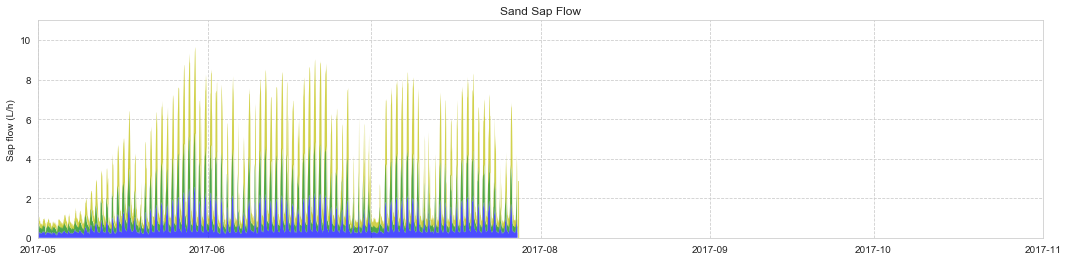

In [36]:
figsize(18,4)
stackplot(SandSap.resample('1h').mean()/1000.)
ylabel('Sap flow (L/h)')
ylim(0,11)
title('Sand Sap Flow')
xlim('2017-05-01','2017-11-01')

(736450.0, 736634.0)

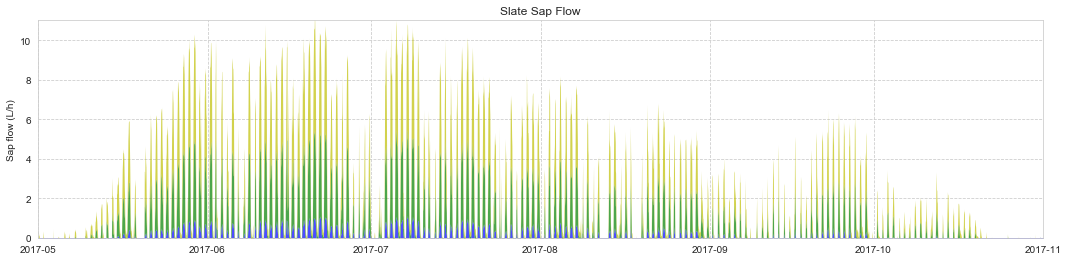

In [37]:
figsize(18,4)
stackplot(SlateSap.resample('1h').mean()/1000.)
ylabel('Sap flow (L/h)')
ylim(0,11)
title('Slate Sap Flow')
xlim('2017-05-01','2017-11-01')

Text(0.5, 1.0, 'Sand Sap Flow')

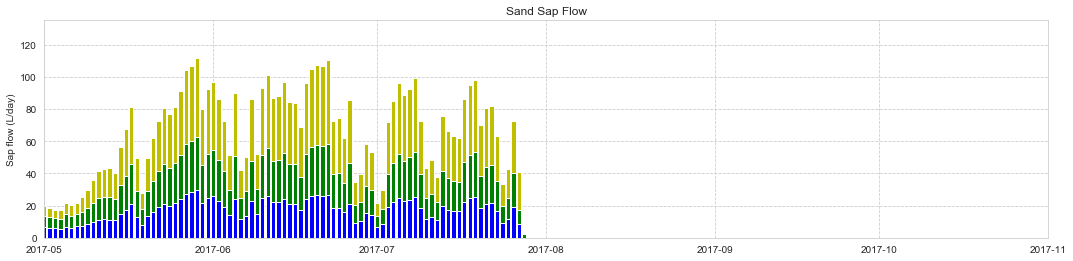

In [79]:
figsize(18,4)
SandSap_d = SandSap.resample('1h').mean().resample('1D').sum()/1000. #daily sap volume in L
for i in SandSap_d.index:
    bar(i,SandSap_d.loc[i,'Sand_SV_inner'],0.8,bottom=SandSap_d.loc[i,'Sand_SV_outer']+SandSap_d.loc[i,'Sand_SV_mid'],color='y')
    bar(i,SandSap_d.loc[i,'Sand_SV_mid'],0.8,bottom=SandSap_d.loc[i,'Sand_SV_outer'],color='g')
    bar(i,SandSap_d.loc[i,'Sand_SV_outer'],0.8,color='b')
xlim('2017-05-01','2017-11-01')
ylim(0,135)
ylabel('Sap flow (L/day)')
title('Sand Sap Flow')

Text(0.5, 1.0, 'Slate Sap Flow')

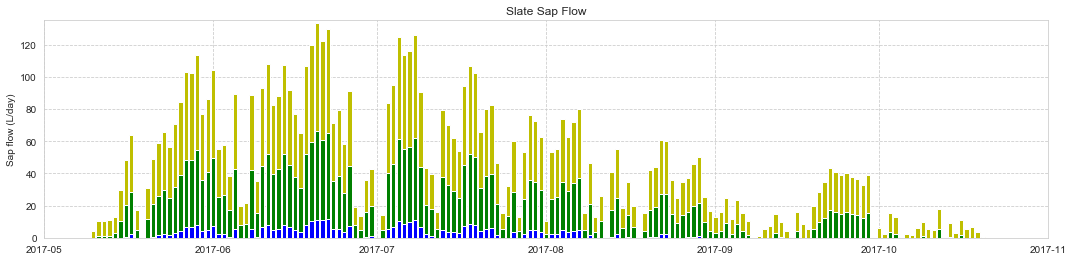

In [80]:
SlateSap_d = SlateSap.resample('1h').mean().resample('1D').sum()/1000. #daily sap volume in L
for i in SlateSap_d.index:
    bar(i,SlateSap_d.loc[i,'Slate_SV_inner'],0.8,bottom=SlateSap_d.loc[i,'Slate_SV_outer']+SlateSap_d.loc[i,'Slate_SV_mid'],color='y')
    bar(i,SlateSap_d.loc[i,'Slate_SV_mid'],0.8,bottom=SlateSap_d.loc[i,'Slate_SV_outer'],color='g')
    bar(i,SlateSap_d.loc[i,'Slate_SV_outer'],0.8,color='b')
xlim('2017-05-01','2017-11-01')
ylim(0,135)
ylabel('Sap flow (L/day)')
title('Slate Sap Flow')

In [82]:
dummy1 = pd.concat([SandSap_d,SlateSap_d],axis=1)
dummy1.columns = ['Sand_SF_inner', 'Sand_SF_mid', 'Sand_SF_outer', 'Slate_SF_inner', 'Slate_SF_mid', 'Slate_SF_outer']
dummy1.to_csv('sapflow.csv')

In [90]:
#Testcases
SVt = pd.read_csv('../rootwater/tests/SV_test.csv',index_col=0)
SVt.index = pd.to_datetime(SVt.index)
sf.sap_calc(SVt,32.,0.95,'beech').to_csv('../rootwater/tests/SF_test.csv')

## RWU and sap reference time series plot

Functions calling the RWU detection algorithm (fRWU) and building a result array are included in rootwater

Call RWU detection for soil moisture data at both sites

In [40]:
[Sand_rwu,Sand_rwunn,Sand_nse] = rw.dfRWUc(SM.loc[:,SM.columns[:12]])

/Users/cojack/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


In [41]:
[Slate_rwu,Slate_rwunn,Slate_nse] = rw.dfRWUc(SM.loc[:,SM.columns[12:]])

Text(0.5, 1.0, 'Daily sap flow volume and RWU estimate from soil moisture change (Slate site)')

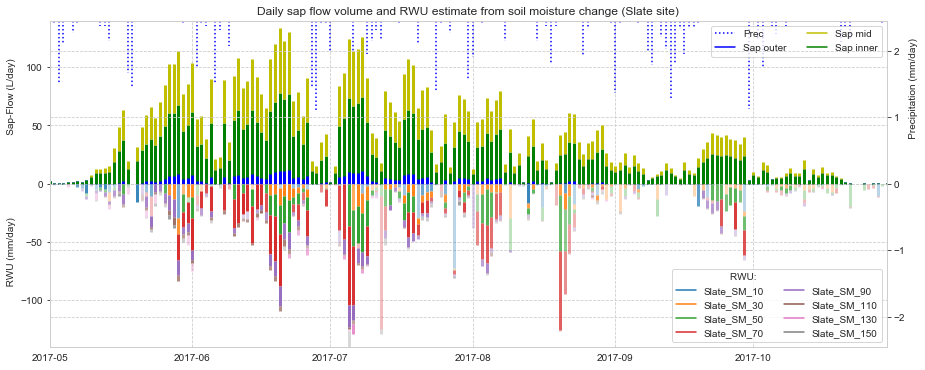

In [44]:
figsize(15,6)
fig, ax1 = plt.subplots(1,1)
ax1.set_ylim([-140,140])
ax1.set_ylabel('         RWU (mm/day)                              Sap-Flow (L/day)')

ax2 = ax1.twinx()

for i in SlateSap_d.index:
    x=np.max([0.,SlateSap_d.loc[i,'Slate_SV_inner']])
    y=np.max([0.,SlateSap_d.loc[i,'Slate_SV_mid']])
    z=np.max([0.,SlateSap_d.loc[i,'Slate_SV_outer']])
    
    ax1.plot([i,i],[0,x],'b-',label='',linewidth=3,solid_capstyle='butt')
    ax1.plot([i,i],[z,x+z],'g-',label='',linewidth=3,solid_capstyle='butt')
    ax1.plot([i,i],[x+z,z+y+x],'y-',label='',linewidth=3,solid_capstyle='butt')
    
    ax1.plot([i,i],[140,(140-(prec_rad.loc[i:i+pd.Timedelta(hours=24),'Slate_Precip'].sum())*4.)],c='blue',linestyle=':')

    count=0
    for l in np.arange(8):
        rwud=Slate_rwu.loc[i,Slate_rwu.columns[l]]

        rwuc=np.min([np.max([0.3,Slate_nse.loc[i,Slate_rwu.columns[l]]]),1])
        if np.isnan(rwuc):
            rwuc=0.1
        ax2.plot([i,i],[count,count-rwud],c=tableau10[l],linestyle='-',linewidth=3,solid_capstyle='butt',alpha=rwuc)
        if isnan(rwud)==False:
            count=count-rwud
            
###legend    
for l in np.arange(8):
    ax2.plot(i,0,c=tableau10[l],label=Slate_rwu.columns[l])
ax1.plot([i],[0],c='blue',linestyle=':',label='Prec')

ax1.plot([i],[0],'b-',label='Sap outer')
ax1.plot([i],[0],'y-',label='Sap mid')
ax1.plot([i],[0],'g-',label='Sap inner')


ax1.legend(loc=1,ncol=2)
ax2.legend(loc=4,ncol=2,title='RWU:                        ')
 
ax2.set_ylim([-2.45,2.45])
ax2.set_ylabel('                                                                       Precipitation (mm/day) ')

ax2.set_xlim(['2017-05-01','2017-10-30'])
title('Daily sap flow volume and RWU estimate from soil moisture change (Slate site)')
#fig.savefig('slate_summary_nse.pdf',bbox_inches='tight')


Text(0.5, 1.0, 'Daily sap AUC and RWU estimate from soil moisture change (Sandstone site)')

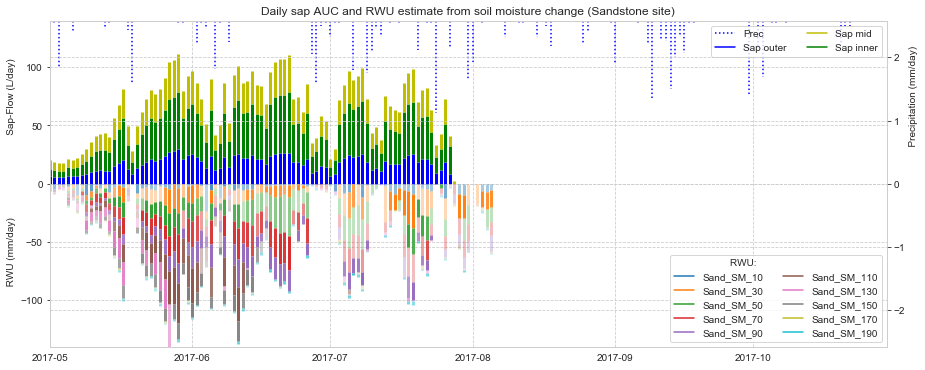

In [45]:
figsize(15,6)
fig, ax1 = plt.subplots(1,1)
ax1.set_ylim([-140,140])
ax1.set_ylabel('         RWU (mm/day)                              Sap-Flow (L/day)')
ax2 = ax1.twinx()


for i in SandSap_d.index:
    x=np.max([0.,SandSap_d.loc[i,'Sand_SV_inner']])
    y=np.max([0.,SandSap_d.loc[i,'Sand_SV_mid']])
    z=np.max([0.,SandSap_d.loc[i,'Sand_SV_outer']])
    
    ax1.plot([i,i],[0,z],'b-',label='',linewidth=3,solid_capstyle='butt')
    ax1.plot([i,i],[z,x+z],'g-',label='',linewidth=3,solid_capstyle='butt')
    ax1.plot([i,i],[x+z,z+y+x],'y-',label='',linewidth=3,solid_capstyle='butt')
    
    ax1.plot([i,i],[140,(140-(prec_rad.loc[i:i+pd.Timedelta(hours=24),'Sand_Precip'].sum())*4.)],c='blue',linestyle=':')

    count=0
    for l in np.arange(10):
        rwud=Sand_rwu.loc[i,Sand_rwu.columns[l]]
        #rwud=SaDrwunn.loc[i,SaD.columns[l]]
        rwuc=np.min([np.max([0.3,Sand_nse.loc[i,Sand_rwu.columns[l]]]),1])
        if np.isnan(rwuc):
            rwuc=0.1
        ax2.plot([i,i],[count,count-rwud],c=tableau10[l],linestyle='-',linewidth=3,solid_capstyle='butt',alpha=rwuc)
        if isnan(rwud)==False:
            count=count-rwud
            
###legende          
for l in np.arange(10):
    ax2.plot(i,0,c=tableau10[l],label=Sand_rwu.columns[l])
ax1.plot([i],[0],c='blue',linestyle=':',label='Prec')

ax1.plot([i],[0],'b-',label='Sap outer')
ax1.plot([i],[0],'y-',label='Sap mid')
ax1.plot([i],[0],'g-',label='Sap inner')


ax2.set_ylim([-2.58,2.58])

ax1.legend(loc=1,ncol=2)
ax2.legend(loc=4,ncol=2,title='RWU:                        ')
 
ax2.set_xlim(['2017-05-01','2017-10-30'])
ax1.set_xlim('2017-05-01','2017-10-30')
ax2.set_ylabel('                                                                  Precipitation (mm/day)  ')

title('Daily sap AUC and RWU estimate from soil moisture change (Sandstone site)')
#savefig('sand_summary_nse.pdf',bbox_inches='tight')


In [46]:
Slatecom = pd.concat([Slate_rwu.sum(axis=1),Slate_rwunn.sum(axis=1),SlateSap_d.sum(axis=1)],axis=1)
Slatecom.columns = ['rwu','rwu_nonight','sap']

Sandcom = pd.concat([Sand_rwu.sum(axis=1),Sand_rwunn.sum(axis=1),SandSap_d.sum(axis=1)],axis=1)
Sandcom.columns = ['rwu','rwu_nonight','sap']

SWcomc=Slatecom.loc['2017-05-01':'2017-10-30']
SWcomc=SWcomc[SWcomc>0].dropna()

SaDcomc=Sandcom.loc['2017-05-01':'2017-07-28']
SaDcomc=SaDcomc[SaDcomc>0].dropna()



In [47]:
def linfit(df,c1='rwu',c2='sap',zeroi=True,pltx=True,applymod=False):
    # linear regression function returning all results (result,x_pred,y_pred,lower,upper,conf) as required for plotting
    import statsmodels.formula.api as smf 
    from statsmodels.sandbox.regression.predstd import wls_prediction_std
    #import statsmodels.api as sm
    from scipy import stats
    df = df.sort_values(by=c2)[[c1,c2]].reset_index()
    if zeroi: #zero intercept
        result = smf.ols(formula=c1+' ~ '+c2+' - 1', data=df).fit()
    else:
        result = smf.ols(formula=c1+' ~ '+c2, data=df).fit()
    y_hat = result.predict(df[c2])
    y_err = df[c1].values - y_hat
    s_err = np.sum(np.power(y_err, 2))
    mean_x = df[c2].mean()
    
    #confidence intervals
    n = len(df)
    x_pred = np.linspace(df[c2].min(), df[c2].max(), 50)
    y_pred = result.predict(pd.Series(x_pred,name=c2))
    dof = n - result.df_model - 1
    t = stats.t.ppf(1-0.05, df=dof)
    conf = t * np.sqrt((s_err/(n-2))*(1.0/n + (np.power((x_pred-mean_x),2) / ((np.sum(np.power(x_pred,2))) - n*(np.power(mean_x,2))))))
    upper = y_pred + abs(conf)
    lower = y_pred - abs(conf)
    
    #prediction interval
    #sdev, lower2, upper2 = wls_prediction_std(result, exog=sm.add_constant(x_pred), alpha=0.05)
    
    if pltx & applymod:
        ax = plt.subplot(gs[0, 0])
        ax.scatter(df[c2], df[c1]/result.params[0], alpha=0.5)
        ax.plot(x_pred, y_pred/result.params[0], '-', linewidth=2)
        ax.fill_between(x_pred, lower/result.params[0], upper/result.params[0], color='#888888', alpha=0.4)
        #ax.fill_between(x_pred, lower2, uppe2, color='#888888', alpha=0.1)
        
        return result
    elif pltx & ~applymod:
        ax = plt.subplot(gs[0, 0])
        ax.scatter(df[c2], df[c1], alpha=0.5)
        ax.plot(x_pred, y_pred, '-', linewidth=2)
        ax.fill_between(x_pred, lower, upper, color='#888888', alpha=0.4)
        return result
    else:
        return result,x_pred,y_pred,lower,upper,conf


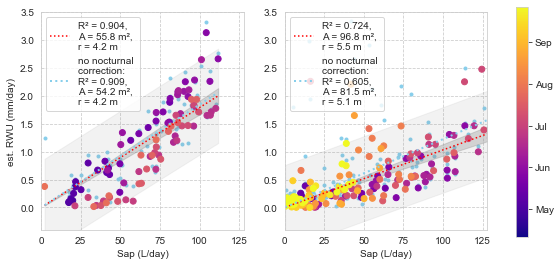

In [48]:
fig = plt.figure(figsize=(8,4))
import matplotlib.gridspec as gridspec
gs = gridspec.GridSpec(1, 2)

ax = plt.subplot(gs[0, 0])

result,x_pred,y_pred,lower,upper,conf = linfit(SaDcomc,c1='rwu_nonight',c2='sap',pltx=False)
#sc2 = ax.scatter(SaDcomc.sap,SaDcomc.rwu_nonight/result.params[0],c='skyblue',marker='.')
sc2 = ax.scatter(SaDcomc.sap,SaDcomc.rwu_nonight,c='skyblue',marker='.')
result2=result

result,x_pred,y_pred,lower,upper,conf = linfit(SaDcomc,c1='rwu',c2='sap',pltx=False)
#ax.fill_between(np.sort(SaDcomc.sap.values),result.get_prediction().summary_frame(alpha=0.05).obs_ci_upper/result.params[0],result.get_prediction().summary_frame(alpha=0.05).obs_ci_lower/result.params[0],color='#888888',alpha=0.1)
#ax.fill_between(np.sort(SaDcomc.sap.values),result.get_prediction().summary_frame(alpha=0.05).mean_ci_upper/result.params[0],result.get_prediction().summary_frame(alpha=0.05).mean_ci_lower/result.params[0],color='#888888',alpha=0.3)
#sc = ax.scatter(SaDcomc.sap,SaDcomc.rwu/result.params[0],c=SaDcomc.index.dayofyear,cmap='plasma',vmin=100,vmax=270)
ax.fill_between(np.sort(SaDcomc.sap.values),result.get_prediction().summary_frame(alpha=0.05).obs_ci_upper,result.get_prediction().summary_frame(alpha=0.05).obs_ci_lower,color='#888888',alpha=0.1)
ax.fill_between(np.sort(SaDcomc.sap.values),result.get_prediction().summary_frame(alpha=0.05).mean_ci_upper,result.get_prediction().summary_frame(alpha=0.05).mean_ci_lower,color='#888888',alpha=0.3)
sc = ax.scatter(SaDcomc.sap,SaDcomc.rwu,c=SaDcomc.index.dayofyear,cmap='plasma',vmin=100,vmax=270)


ax.plot(x_pred,y_pred,'r:',label='R² = %s, \nA = %s m², \nr = %s m'%(round(result.rsquared,3),round(1./result.params[0],1),round(np.sqrt((1./result.params[0])/np.pi),1)))
ax.plot([SaDcomc.sap.min(),SaDcomc.sap.max()],[result2.predict().min(),result2.predict().max()],':',c='skyblue',lw=2,label='no nocturnal \ncorrection: \nR² = %s, \nA = %s m², \nr = %s m'%(round(result2.rsquared,3),round(1./result2.params[0],1),round(np.sqrt((1./result2.params[0])/np.pi),1)))


result1=result



ax.set_xlim(0,128)
#ax.set_ylim(0,128)
ax.set_ylim(-0.4,3.5)
ax.set_ylabel('est. RWU (mm/day)')
ax.set_xlabel('Sap (L/day)')
#ax.set_title('Sandstone Site')
ax.legend(loc=2)

ax = plt.subplot(gs[0, 1])

result,x_pred,y_pred,lower,upper,conf = linfit(SWcomc,c1='rwu_nonight',c2='sap',pltx=False)
#sc2 = ax.scatter(SWcomc.sap,SWcomc.rwu_nonight/result.params[0],c='skyblue',marker='.')
sc2 = ax.scatter(SWcomc.sap,SWcomc.rwu_nonight,c='skyblue',marker='.')
result4=result

result,x_pred,y_pred,lower,upper,conf = linfit(SWcomc,c1='rwu',c2='sap',pltx=False)
#ax.fill_between(np.sort(SWcomc.sap.values),result.get_prediction().summary_frame(alpha=0.05).obs_ci_upper/result.params[0],result.get_prediction().summary_frame(alpha=0.05).obs_ci_lower/result.params[0],color='#888888',alpha=0.1)
#ax.fill_between(np.sort(SWcomc.sap.values),result.get_prediction().summary_frame(alpha=0.05).mean_ci_upper/result.params[0],result.get_prediction().summary_frame(alpha=0.05).mean_ci_lower/result.params[0],color='#888888',alpha=0.3)

#ax.plot([SWcomc.sap.min(),SWcomc.sap.max()],[result.predict().min()/result.params[0],result.predict().max()/result.params[0]],'r:',label='R² = %s, \nA = %s m², \nr = %s m'%(round(result.rsquared,3),round(1/result.params[0],1),round(np.sqrt((1./result.params[0])/np.pi),1)))
#ax.plot([SWcomc.sap.min(),SWcomc.sap.max()],[result4.predict().min()/result4.params[0],result4.predict().max()/result4.params[0]],':',c='skyblue',lw=2,label='no nocturnal \ncorrection: \nR² = %s, \nA = %s m², \nr = %s m'%(round(result4.rsquared,3),round(1./result4.params[0],1),round(np.sqrt((1./result4.params[0])/np.pi),1)))

#sc = ax.scatter(SWcomc.sap,SWcomc.rwu/result.params[0],c=SWcomc.index.dayofyear,cmap='plasma',vmin=100,vmax=270)
ax.fill_between(np.sort(SWcomc.sap.values),result.get_prediction().summary_frame(alpha=0.05).obs_ci_upper,result.get_prediction().summary_frame(alpha=0.05).obs_ci_lower,color='#888888',alpha=0.1)
ax.fill_between(np.sort(SWcomc.sap.values),result.get_prediction().summary_frame(alpha=0.05).mean_ci_upper,result.get_prediction().summary_frame(alpha=0.05).mean_ci_lower,color='#888888',alpha=0.3)

ax.plot([SWcomc.sap.min(),SWcomc.sap.max()],[result.predict().min(),result.predict().max()],'r:',label='R² = %s, \nA = %s m², \nr = %s m'%(round(result.rsquared,3),round(1/result.params[0],1),round(np.sqrt((1./result.params[0])/np.pi),1)))
ax.plot([SWcomc.sap.min(),SWcomc.sap.max()],[result4.predict().min(),result4.predict().max()],':',c='skyblue',lw=2,label='no nocturnal \ncorrection: \nR² = %s, \nA = %s m², \nr = %s m'%(round(result4.rsquared,3),round(1./result4.params[0],1),round(np.sqrt((1./result4.params[0])/np.pi),1)))


sc = ax.scatter(SWcomc.sap,SWcomc.rwu,c=SWcomc.index.dayofyear,cmap='plasma',vmin=100,vmax=270)


result3=result


ax.set_xlim(0,128)
ax.set_ylim(-0.4,3.5)
ax.set_xlabel('Sap (L/day)')
#ax.set_title('Slate Site') 
ax.legend(loc=2)

cb_ax = fig.add_axes([0.95, 0.1, 0.02, 0.8])
cbar = fig.colorbar(sc, cax=cb_ax,label='',ticks=(121,152,182,213,244))
cbar.set_ticklabels(['May','Jun','Jul','Aug','Sep'])

#savefig('RWU_reg2.pdf',bbox_inches='tight')




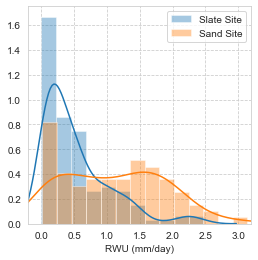

In [138]:
figsize(4,4)
sns.distplot((SWcomc.rwu),bins=11,label='Slate Site')
sns.distplot((SaDcomc.rwu),bins=14,label='Sand Site')
xlim(-0.2,3.2)
xlabel('RWU (mm/day)')
legend()

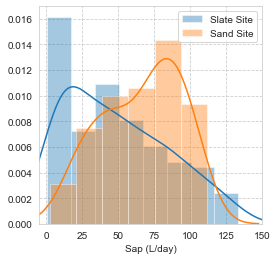

In [137]:
figsize(4,4)
sns.distplot((SWcomc.sap),bins=8,label='Slate Site')
sns.distplot((SaDcomc.sap),bins=6,label='Sand Site')
xlim(-5,150)
xlabel('Sap (L/day)')
legend()

(-0.8, 11.8)

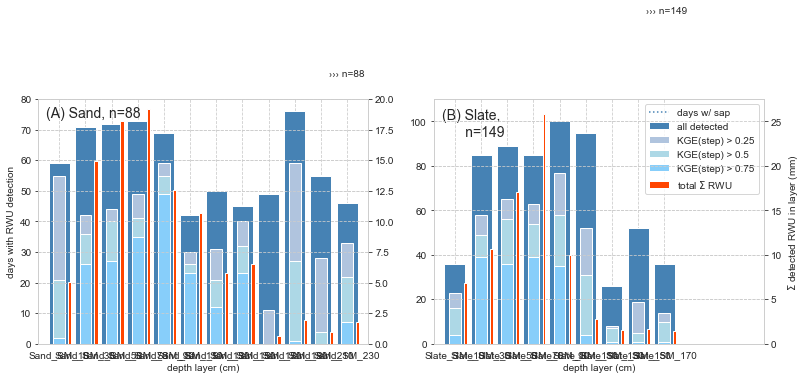

In [49]:
figsize(13,4.5)
ax1 = plt.subplot(122)
#SW
ax1.bar(Slate_rwu.columns,(~np.isnan(Slate_rwu.loc[SWcomc.index[0]:SWcomc.index[-1]])).astype(int).sum(axis=0),label='all detected',facecolor='steelblue')
#0.5 KGE threshold
ax1.bar(Slate_rwu.columns,((Slate_nse.loc[(~np.isnan(Slate_rwu.loc[SWcomc.index[0]:SWcomc.index[-1]])).index]>0.25) & (~np.isnan(Slate_rwu.loc[SWcomc.index[0]:SWcomc.index[-1]]))).astype(int).sum(axis=0),width=0.45,alpha=1,facecolor='lightsteelblue',label='KGE(step) > 0.25')
ax1.bar(Slate_rwu.columns,((Slate_nse.loc[(~np.isnan(Slate_rwu.loc[SWcomc.index[0]:SWcomc.index[-1]])).index]>0.5) & (~np.isnan(Slate_rwu.loc[SWcomc.index[0]:SWcomc.index[-1]]))).astype(int).sum(axis=0),width=0.45,alpha=1,facecolor='lightblue',label='KGE(step) > 0.5')
ax1.bar(Slate_rwu.columns,((Slate_nse.loc[(~np.isnan(Slate_rwu.loc[SWcomc.index[0]:SWcomc.index[-1]])).index]>0.75) & (~np.isnan(Slate_rwu.loc[SWcomc.index[0]:SWcomc.index[-1]]))).astype(int).sum(axis=0),width=0.45,alpha=1,facecolor='lightskyblue',label='KGE(step) > 0.75')
#10% percentile threshold
#ax1.bar(Slate_rwu.columns,(Slate_rwu.loc[SWcomc.index[0]:SWcomc.index[-1]]>np.percentile(Slate_rwu.values[Slate_rwu.values>0.],10)).astype(int).sum(axis=0),width=0.45,alpha=1,label='>10% percentile')
#fixed threshold
#ax1.bar(Slate_rwu.columns,(Slate_rwu.loc[SWcomc.index[0]:SWcomc.index[-1]]>0.05).astype(int).sum(axis=0),width=0.3,alpha=1,label='>0.05 mm/day')
ax1.plot([1,7.3],[(SWcomc['sap']>0.05).astype(int).sum(),(SWcomc['sap']>0.05).astype(int).sum()],':',c='steelblue',label='days w/ sap')
ax1.text(7.32,(SWcomc['sap']>0.05).astype(int).sum()-0.5,'››› n='+str((SWcomc['sap']>0.05).astype(int).sum()))
ax1.text(-0.5,93.5,'(B) Slate, \n      n='+str((SWcomc['sap']>0.1).astype(int).sum()),fontsize=14)
ax1.bar(0,0,facecolor='orangered',width=0.1,label='total $\Sigma$ RWU')
xlabel('depth layer (cm)')
#ax1.set_ylabel('days with RWU detection')
ax1.legend(loc=1)

ax2 = ax1.twinx()
ax2.bar(np.arange(len(Slate_rwu.columns))+0.4,Slate_rwu.loc[SWcomc.index[0]:SWcomc.index[-1]].sum(axis=0),facecolor='orangered',width=0.1)
ax2.set_ylim(0,27.5)
ax1.set_ylim(0,110)
ax1.set_xlim(-0.8,11.8)

ax2.set_ylabel('$\Sigma$ detected RWU in layer (mm)')


ax1 = plt.subplot(121)
#SaD
ax1.bar(Sand_rwu.columns,(~np.isnan(Sand_rwu.loc[SaDcomc.index[0]:SaDcomc.index[-1]])).astype(int).sum(axis=0),facecolor='steelblue')
#0.5 KGE threshold
ax1.bar(Sand_rwu.columns,((Sand_nse.loc[(~np.isnan(Sand_rwu.loc[SaDcomc.index[0]:SaDcomc.index[-1]])).index]>0.25) & (~np.isnan(Sand_rwu.loc[SaDcomc.index[0]:SaDcomc.index[-1]]))).astype(int).sum(axis=0),width=0.45,alpha=1,facecolor='lightsteelblue',label='KGE > 0.25')
ax1.bar(Sand_rwu.columns,((Sand_nse.loc[(~np.isnan(Sand_rwu.loc[SaDcomc.index[0]:SaDcomc.index[-1]])).index]>0.5) & (~np.isnan(Sand_rwu.loc[SaDcomc.index[0]:SaDcomc.index[-1]]))).astype(int).sum(axis=0),width=0.45,alpha=1,facecolor='lightblue',label='KGE > 0.5')
ax1.bar(Sand_rwu.columns,((Sand_nse.loc[(~np.isnan(Sand_rwu.loc[SaDcomc.index[0]:SaDcomc.index[-1]])).index]>0.75) & (~np.isnan(Sand_rwu.loc[SaDcomc.index[0]:SaDcomc.index[-1]]))).astype(int).sum(axis=0),width=0.45,alpha=1,facecolor='lightskyblue',label='KGE > 0.75')
#10% percentile threshold
#ax1.bar(Sand_rwu.columns,(Sand_rwu.loc[SaDcomc.index[0]:SaDcomc.index[-1]]>np.percentile(Sand_rwu.values[Sand_rwu.values>0.],10)).astype(int).sum(axis=0),width=0.45,alpha=1)
#fixed threshold
#ax1.bar(Sand_rwu.columns,(Sand_rwu.loc[SaDcomc.index[0]:SaDcomc.index[-1]]>0.05).astype(int).sum(axis=0),width=0.3,alpha=1)
ax1.plot([1.5,10.3],[(SaDcomc['sap']>0.05).astype(int).sum(),(SaDcomc['sap']>0.05).astype(int).sum()],':',c='steelblue')
ax1.text(10.32,(SaDcomc['sap']>0.05).astype(int).sum()-0.5,'››› n='+str((SaDcomc['sap']>0.05).astype(int).sum()))
ax1.text(-0.5,73.9,'(A) Sand, n='+str((SaDcomc['sap']>0.1).astype(int).sum()),fontsize=14)
ax1.bar(0,0,facecolor='orangered',width=0.1,label='total $\Sigma$ RWU')
xlabel('depth layer (cm)')
ax1.set_ylabel('days with RWU detection')

ax2 = ax1.twinx()
ax2.bar(np.arange(len(Sand_rwu.columns))+0.4,Sand_rwu.loc[SaDcomc.index[0]:SaDcomc.index[-1]].sum(axis=0),facecolor='orangered',width=0.13)
#ax2.set_ylim(0,19.71)
ax1.set_ylim(0,80)
ax2.set_ylim(0,20)
ax1.set_xlim(-0.8,11.8)


#savefig('RWUdetect_new.pdf',bbox_inches='tight')


Text(0.5, 1, '(B)\nSlate')

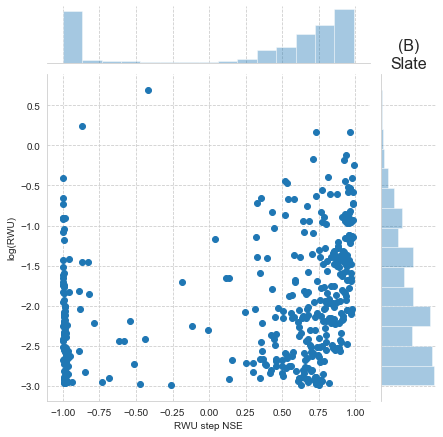

In [50]:
h = sns.jointplot((Slate_nse[Slate_rwu>0.05]).values[~np.isnan((Slate_nse[Slate_rwu>0.05]).values)],np.log((Slate_rwu[Slate_rwu>0.05]).values[~np.isnan((Slate_rwu[Slate_rwu>0.05]).values)]),marginal_kws=dict(bins=15))
h.set_axis_labels('RWU step NSE','log(RWU)')
title('(B)\nSlate',fontsize=16)
#savefig('RWU_SWnse.pdf',bbox_inches='tight')

Text(0.5, 1, '(A)\nSand')

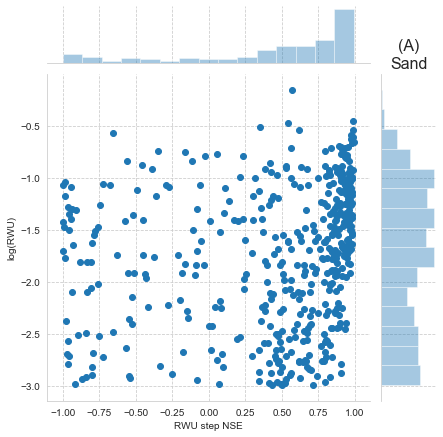

In [51]:
h = sns.jointplot((Sand_nse[Sand_rwu>0.05]).values[~np.isnan((Sand_nse[Sand_rwu>0.05]).values)],np.log((Sand_rwu[Sand_rwu>0.05]).values[~np.isnan((Sand_rwu[Sand_rwu>0.05]).values)]),marginal_kws=dict(bins=15))
h.set_axis_labels('RWU step NSE','log(RWU)')
title('(A)\nSand',fontsize=16)
#savefig('RWU_SaDnse.pdf',bbox_inches='tight')

## Correlation of RWU and Sap time series

In [52]:
#rolling functions of Spearman rho and KGE
def spear_roll(ts,win=21,rf1='rwu',rf2='sapAUC'):
    if len(ts.columns)==2:
        rf1,rf2 = ts.columns
    
    if win == 0:
        xs = ts[rf1].copy()*0
        xs += sp.stats.mstats.spearmanr(ts.loc[:,rf2],ts.loc[:,rf1])[0]
    else:
        xs = ts[rf1].copy()*np.nan
        win2 = int(np.floor(win/2)) #use center of moving window
        for i in np.arange(len(ts))[win2:-(win2+1)]:
            xs.loc[ts.index[i]] = sp.stats.mstats.spearmanr(ts.loc[ts.index[i-win2]:ts.index[i+win2],rf2],ts.loc[ts.index[i-win2]:ts.index[i+win2],rf1])[0]
    return xs

def kge_roll(ts,win=21,rf1='rwu',rf2='sapAUC',linreg=False):
    if len(ts.columns)==2:
        rf1,rf2 = ts.columns
    
    if win==0:
        xs = ts[rf1].copy()*0
        if linreg:
            result = smf.ols(formula=rf1+' ~ '+rf2+' -1', data=ts).fit()
            xs += he.kge(ts.loc[:,rf1].values,(ts.loc[:,rf2]*result.params[0]).values)[0]
        else:
            xs += he.kge(ts.loc[:,rf1].values,ts.loc[:,rf2].values)[0]
    else:
        xs = ts[rf1].copy()*np.nan
        win2 = int(np.floor(win/2)) #use center of moving window
        for i in np.arange(len(ts))[win2:-(win2+1)]:
            if linreg:
                result = smf.ols(formula=rf1+' ~ '+rf2+' -1', data=ts.loc[ts.index[i-win2]:ts.index[i+win2]]).fit()
                xs.loc[ts.index[i]] = he.kge(ts.loc[ts.index[i-win2]:ts.index[i+win2],rf1].values,(ts.loc[ts.index[i-win2]:ts.index[i+win2],rf2]*result.params[0]).values)[0]
            else:
                xs.loc[ts.index[i]] = he.kge(ts.loc[ts.index[i-win2]:ts.index[i+win2],rf1].values,ts.loc[ts.index[i-win2]:ts.index[i+win2],rf2].values)[0]
    return xs

In [53]:
#convert RWU to volume flux by assuming a cylindrical rhizosphere and water balance with sap flow
result = smf.ols(formula='rwu ~ sap - 1', data=SWcomc).fit()
SWcomc['rwu_V'] = SWcomc.rwu/result.params[0]

result = smf.ols(formula='rwu ~ sap - 1', data=SaDcomc).fit()
SaDcomc['rwu_V'] = SaDcomc.rwu/result.params[0]

In [54]:
result = smf.ols(formula='rwu_nonight ~ sap - 1', data=SWcomc).fit()
SWcomc['rwuNN_V'] = SWcomc.rwu_nonight/result.params[0]

result = smf.ols(formula='rwu_nonight ~ sap - 1', data=SaDcomc).fit()
SaDcomc['rwuNN_V'] = SaDcomc.rwu_nonight/result.params[0]

Text(0, 0.5, 'Spearman rho')

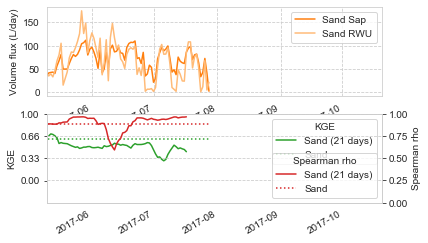

In [55]:
figsize(6,4)
subplot(211)
SaDcomc['sap'].plot(c=tableau20[2],label='Sand Sap')
SaDcomc['rwu_V'].plot(c=tableau20[3],label='Sand RWU')


#SWcomc_V['sapAUC'].plot(c=tableau20[0],label='Slate Sap')
#SWcomc_V['rwu'].plot(c=tableau20[1],label='Slate RWU')

#ylim(0,70)
xlim(SWcomc.index[0],SWcomc.index[-1])
legend()
ylabel('Volume flux (L/day)')

subplot(212)
SaDcomc[['sap','rwu_V']].pipe(kge_roll).plot(c=tableau20[4],label='Sand (21 days)')
plot([SaDcomc.index[0],SaDcomc.index[-1]],[he.kge(SaDcomc['sap'].values,SaDcomc['rwu_V'].values)[0],he.kge(SaDcomc['sap'].values,SaDcomc['rwu_V'].values)[0]],':',c=tableau20[4],label='Sand')
ylim(-0.33,1)
yticks([0.,0.33,0.66,1])
legend(title='KGE')
ylabel('KGE')

SaDcomc[['sap','rwu_V']].pipe(spear_roll).plot(secondary_y=True,c=tableau20[6],label='Sand (21 days)')
plot([SaDcomc.index[0],SaDcomc.index[-1]],[sp.stats.mstats.spearmanr(SaDcomc['sap'],SaDcomc['rwu_V'])[0],sp.stats.mstats.spearmanr(SaDcomc['sap'],SaDcomc['rwu_V'])[0]],':',c=tableau20[6],label='Sand')

legend(title='Spearman rho',loc=4)
ylim(0,1)
xlim(SWcomc.index[0],SWcomc.index[-1])
ylabel('Spearman rho')

#savefig('sand_cor_raw.pdf',bbox_inches='tight')


In [56]:
#gof rs and KGE :: Sand SF vs. RWU 
sp.stats.mstats.spearmanr(SaDcomc['sap'],SaDcomc['rwu_V'])[0],he.kge(SaDcomc['sap'].values,SaDcomc['rwu_V'].values)[0][0]

(0.8862139410376528, 0.6196591567251213)

In [57]:
#gof rs and KGE :: Sand SF vs. RWU no nocturnal correction
sp.stats.mstats.spearmanr(SaDcomc['sap'],SaDcomc['rwuNN_V'])[0],he.kge(SaDcomc['sap'].values,SaDcomc['rwuNN_V'].values)[0][0]

(0.8496002254235497, 0.6565935747093112)

Text(0, 0.5, 'Spearman rho')

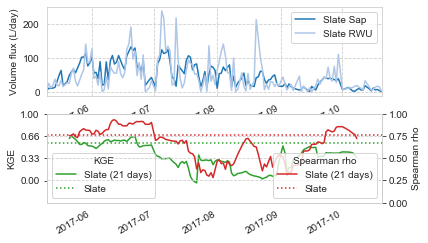

In [58]:
figsize(6,4)
subplot(211)

SWcomc['sap'].plot(c=tableau20[0],label='Slate Sap')
SWcomc['rwu_V'].plot(c=tableau20[1],label='Slate RWU')

xlim(SWcomc.index[0],SWcomc.index[-1])
legend()
ylabel('Volume flux (L/day)')

subplot(212)
SWcomc[['sap','rwu_V']].pipe(kge_roll).plot(c=tableau20[4],label='Slate (21 days)')
plot([SWcomc.index[0],SWcomc.index[-1]],[he.kge(SWcomc['sap'].values,SWcomc['rwu_V'].values)[0],he.kge(SWcomc['sap'].values,SWcomc['rwu_V'].values)[0]],':',c=tableau20[4],label='Slate')
ylim(-0.33,1)
yticks([0.,0.33,0.66,1])
legend(title='KGE')
ylabel('KGE')

SWcomc[['sap','rwu_V']].pipe(spear_roll).plot(secondary_y=True,c=tableau20[6],label='Slate (21 days)')
plot([SWcomc.index[0],SWcomc.index[-1]],[sp.stats.mstats.spearmanr(SWcomc['sap'],SWcomc['rwu_V'])[0],sp.stats.mstats.spearmanr(SWcomc['sap'],SWcomc['rwu_V'])[0]],':',c=tableau20[6],label='Slate')

legend(title='Spearman rho',loc=4)
ylim(0,1)
xlim(SWcomc.index[0],SWcomc.index[-1])
ylabel('Spearman rho')

#savefig('slate_cor_raw.pdf',bbox_inches='tight')


In [59]:
#gof rs and KGE :: Slate SF vs. RWU
sp.stats.mstats.spearmanr(SWcomc['sap'],SWcomc['rwu_V'])[0],he.kge(SWcomc['sap'].values,SWcomc['rwu_V'].values)[0][0]

(0.7591547251949937, 0.5565136803470871)

In [60]:
#gof rs and KGE :: Sand SF vs. RWU no nocturnal correction
sp.stats.mstats.spearmanr(SWcomc['sap'],SWcomc['rwuNN_V'])[0],he.kge(SWcomc['sap'].values,SWcomc['rwuNN_V'].values)[0][0]

(0.6742796092176031, 0.37863838836851427)

Text(0, 0.5, 'Spearman rho')

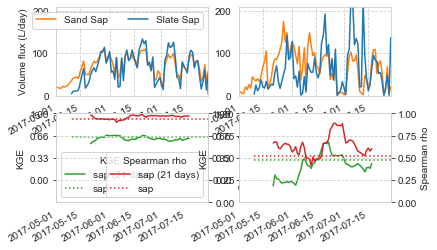

In [61]:
figsize(6,4)
subplot(221)
SaDcomc['sap'].plot(c=tableau20[2],label='Sand Sap')
SWcomc['sap'].plot(c=tableau20[0],label='Slate Sap')

ylim(0,210)
xlim(SaDcomc.index[0],SaDcomc.index[-1])
legend(ncol=2,loc=1)
ylabel('Volume flux (L/day)')

subplot(222)
SaDcomc['rwu_V'].plot(c=tableau20[2],label='Sand RWU')
SWcomc['rwu_V'].plot(c=tableau20[0],label='Slate RWU')

ylim(0,210)
xlim(SaDcomc.index[0],SaDcomc.index[-1])


subplot(223)
c_dummy = pd.concat([SaDcomc['sap'],SWcomc['sap']],axis=1,join='inner')
c_dummy.columns = ['sap','rwu']
c_dummy.pipe(kge_roll).plot(c=tableau20[4],label='sap (21 days)')
plot([c_dummy.index[0],c_dummy.index[-1]],[he.kge(c_dummy['sap'].values,c_dummy['rwu'].values)[0],he.kge(c_dummy['sap'].values,c_dummy['rwu'].values)[0]],':',c=tableau20[4],label='sap')
ylim(-0.33,1)
yticks([0.,0.33,0.66,1])
legend(title='KGE')
ylabel('KGE')

c_dummy[['sap','rwu']].pipe(spear_roll).plot(secondary_y=True,c=tableau20[6],label='sap (21 days)')
plot([c_dummy.index[0],c_dummy.index[-1]],[sp.stats.mstats.spearmanr(c_dummy['sap'],c_dummy['rwu'])[0],sp.stats.mstats.spearmanr(c_dummy['sap'],c_dummy['rwu'])[0]],':',c=tableau20[6],label='sap')

legend(title='Spearman rho',loc=4)
ylim(0,1)
xlim(SaDcomc.index[0],SaDcomc.index[-1])
ylabel('Spearman rho')


subplot(224)
c1_dummy = pd.concat([SaDcomc['rwu_V'],SWcomc['rwu_V']],axis=1,join='inner')
c1_dummy.columns = ['sapAUC','rwu']
c1_dummy.pipe(kge_roll).plot(c=tableau20[4],label='rwu (21 days)')
plot([c1_dummy.index[0],c1_dummy.index[-1]],[he.kge(c1_dummy['sapAUC'].values,c1_dummy['rwu'].values)[0],he.kge(c1_dummy['sapAUC'].values,c1_dummy['rwu'].values)[0]],':',c=tableau20[4],label='rwu')
ylim(-0.33,1)
yticks([0.,0.33,0.66,1])
ylabel('KGE')

c1_dummy[['sapAUC','rwu']].pipe(spear_roll).plot(secondary_y=True,c=tableau20[6],label='rwu (21 days)')
plot([c1_dummy.index[0],c1_dummy.index[-1]],[sp.stats.mstats.spearmanr(c1_dummy['sapAUC'],c1_dummy['rwu'])[0],sp.stats.mstats.spearmanr(c1_dummy['sapAUC'],c1_dummy['rwu'])[0]],':',c=tableau20[6],label='rwu')

ylim(0,1)
xlim(SaDcomc.index[0],SaDcomc.index[-1])
ylabel('Spearman rho')

#savefig('spatial_cor_raw.pdf',bbox_inches='tight')


In [62]:
#gof rs and KGE :: Sand SF vs. Slate SF
sp.stats.mstats.spearmanr(c_dummy['sap'],c_dummy['rwu'])[0],he.kge(c_dummy['sap'].values,c_dummy['rwu'].values)[0][0]

(0.9410326515589673, 0.649790149119509)

In [63]:
#gof rs and KGE :: Sand RWU vs. Slate RWU
sp.stats.mstats.spearmanr(c1_dummy['sapAUC'],c1_dummy['rwu'])[0],he.kge(c1_dummy['sapAUC'].values,c1_dummy['rwu'].values)[0][0]

(0.5175876754824124, 0.30311623610738714)

In [64]:
#check effect of nocturnal correction
c2_dummy = pd.concat([SaDcomc['rwu_V'],SWcomc['rwuNN_V']],axis=1,join='inner')
c3_dummy = pd.concat([SaDcomc['rwuNN_V'],SWcomc['rwu_V']],axis=1,join='inner')
c4_dummy = pd.concat([SaDcomc['rwuNN_V'],SWcomc['rwuNN_V']],axis=1,join='inner')
c5_dummy = pd.concat([SaDcomc['rwu_V'],SWcomc['rwu_V']],axis=1,join='inner')

In [65]:
[sp.stats.mstats.spearmanr(c2_dummy.iloc[:,0],c2_dummy.iloc[:,1])[0],
sp.stats.mstats.spearmanr(c3_dummy.iloc[:,0],c3_dummy.iloc[:,1])[0],
sp.stats.mstats.spearmanr(c4_dummy.iloc[:,0],c4_dummy.iloc[:,1])[0],
sp.stats.mstats.spearmanr(c5_dummy.iloc[:,0],c5_dummy.iloc[:,1])[0]]

[0.46122905031917727,
 0.4907986750092013,
 0.4167203418039945,
 0.5175876754824124]

In [66]:
[he.kge(c2_dummy.iloc[:,0].values,c2_dummy.iloc[:,1].values)[0],
he.kge(c3_dummy.iloc[:,0].values,c3_dummy.iloc[:,1].values)[0],
he.kge(c4_dummy.iloc[:,0].values,c4_dummy.iloc[:,1].values)[0],
he.kge(c5_dummy.iloc[:,0].values,c5_dummy.iloc[:,1].values)[0]]

[array([0.3241462]),
 array([0.23824204]),
 array([0.26613051]),
 array([0.30311624])]

## RWU sourcing

In [67]:
SWcom3 = pd.concat([Slate_rwu,MP[['Slate_MP_10', 'Slate_MP_30', 'Slate_MP_50', 'Slate_MP_70', 'Slate_MP_90','Slate_MP_110', 'Slate_MP_130', 'Slate_MP_150', 'Slate_MP_170']].resample('1D').mean(),SlateSap_d.sum(axis=1)],axis=1)
SWcom3.columns = ['10',   '30',   '50',   '70',   '90',  '110',  '130',  '150',  '170', 'p10',  'p30',  'p50',  'p70',  'p90', 'p110', 'p130', 'p150', 'p170','sap']

In [68]:
SaDcom3 = pd.concat([Sand_rwu,MP[['Sand_MP_10', 'Sand_MP_30', 'Sand_MP_50', 'Sand_MP_70', 'Sand_MP_90','Sand_MP_110', 'Sand_MP_130', 'Sand_MP_150', 'Sand_MP_170', 'Sand_MP_190', 'Sand_MP_210', 'Sand_MP_230']].resample('1D').mean(),SandSap_d.sum(axis=1)],axis=1)
SaDcom3.columns = ['10',   '30',   '50',   '70',   '90',  '110',  '130',  '150',  '170', '190', '210', '230', 'p10',  'p30',  'p50',  'p70',  'p90', 'p110', 'p130', 'p150', 'p170','p190', 'p210', 'p230','sap']

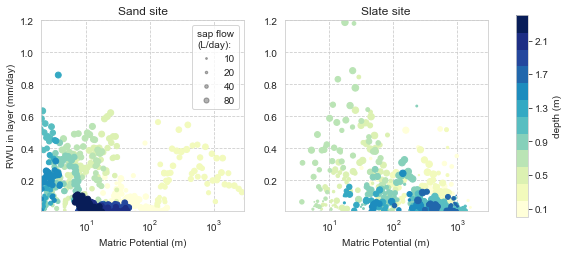

In [69]:
fig = plt.figure(figsize=(8,3.5))
import matplotlib.gridspec as gridspec
gs = gridspec.GridSpec(1, 2)

ax = plt.subplot(gs[0, 0])
cmapx = cm.get_cmap('YlGnBu',12)
for i in Sand_rwu.columns:
    cl = 'p'+i.split('_')[-1]
    ci = i.split('_')[-1]
    sc = ax.scatter(-1.*(SaDcom3[cl]),SaDcom3[ci],c=np.repeat((float(ci))/100.,len(SaDcom3[ci])),s=SaDcom3.sap/3.,cmap=cmapx,vmin=0,vmax=2.4)
    
ax.scatter(0,0,c='k',s=10/3.,label='10',alpha=0.3)
ax.scatter(0,0,c='k',s=20/3.,label='20',alpha=0.3)
ax.scatter(0,0,c='k',s=40/3.,label='40',alpha=0.3)
ax.scatter(0,0,c='k',s=80/3.,label='80',alpha=0.3)

ax.set_ylabel('RWU in layer (mm/day)')
ax.set_xlabel('Matric Potential (m)')
ax.legend(title='sap flow\n(L/day):')
ax.set_xlim(2,3000)
ax.set_ylim(0.01,1.2)
ax.set_title('Sand site')
ax.set_xscale('log')

ax = plt.subplot(gs[0, 1])

for i in Slate_rwu.columns:
    cl = 'p'+i.split('_')[-1]
    ci = i.split('_')[-1]
    sc = ax.scatter(-1.*(SWcom3[cl]),SWcom3[ci],c=np.repeat((float(ci))/100.,len(SWcom3[ci])),s=SWcom3.sap/3.,cmap=cmapx,vmin=0,vmax=2.4)

ax.set_xlabel('Matric Potential (m)')
ax.set_xlim(2,3000)
ax.set_ylim(0.01,1.2)
ax.set_title('Slate site')
ax.set_xscale('log')
cb_ax = fig.add_axes([0.95, 0.1, 0.02, 0.8])
cbar = fig.colorbar(sc, cax=cb_ax,label='depth (m)',ticks=[0.1, 0.5, 0.9,1.3,1.7,2.1])

#savefig('RWUsourcing_new.pdf',bbox_inches='tight')


## Site event soil water balance

In [70]:
def cumplot(dummy,rain,dpth):
    dummy = dummy.iloc[:,:]-dummy.iloc[0,:]
    dum_sum= dummy.cumsum(axis=1)
    dum2 = dum_sum.iloc[:,0]*0.
    dum2.name='0'
    dum_sum=pd.concat([dum2,dum_sum],axis=1)

    for i in np.arange(len(dpth)):
        if i<10:
            ci=tableau10[i]
        if i>=10:
            ci=tableau20[(i-10)*2+1]
        fill_between(dum_sum.index, dum_sum.iloc[:,i], dum_sum.iloc[:,i+1], color=ci,alpha=0.6,label=dpth[i]+' cm')
        plot(dum_sum.index,dum_sum.iloc[:,i+1],c=ci,alpha=0.8,label='')
                         
    plot(rain, label='Precip')
    ylabel('∆ water (mm)' )
    legend(ncol=2)

    return
    

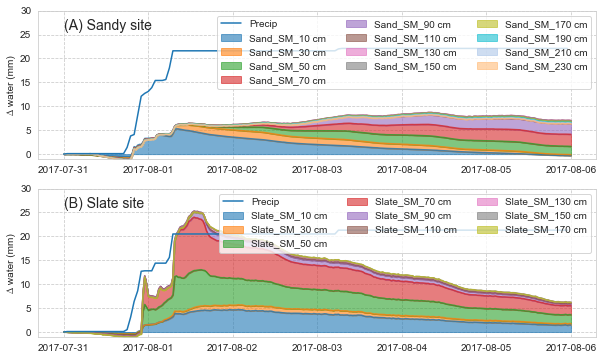

In [71]:
t_start = pd.to_datetime('2017-07-31')
t_end = pd.to_datetime('2017-8-6')

figsize(10,6)

subplot(211)
dpth = ['Sand_SM_10', 'Sand_SM_30', 'Sand_SM_50', 'Sand_SM_70', 'Sand_SM_90',
       'Sand_SM_110', 'Sand_SM_130', 'Sand_SM_150', 'Sand_SM_170',
       'Sand_SM_190', 'Sand_SM_210', 'Sand_SM_230']
cumplot(SM.loc[t_start:t_end,dpth],prec_rad.loc[t_start:t_end,'Sand_Precip'].resample('1h').max().cumsum(),dpth)
text(t_start,26,'(A) Sandy site',fontsize=14)
ylim([-1,30])
legend(loc=1,ncol=3)
#xticklabel('')
#title('Sandstone site')

subplot(212)
dpth = ['Slate_SM_10', 'Slate_SM_30', 'Slate_SM_50', 'Slate_SM_70', 'Slate_SM_90',
       'Slate_SM_110', 'Slate_SM_130', 'Slate_SM_150', 'Slate_SM_170']
cumplot(SM.loc[t_start:t_end,dpth],prec_rad.loc[t_start:t_end,'Slate_Precip'].resample('1h').max().cumsum(),dpth)
text(t_start,26,'(B) Slate site',fontsize=14)
ylim([-1,30])
legend(loc=1,ncol=3)
#title('Slate site')

#savefig('WB_0817.pdf',bbox_inches='tight')